<a href="https://colab.research.google.com/github/NavdeepTU/Deep-Learning/blob/main/02.%20ML%20basics%20with%20Keras/06.%20Overfit%20and%20underfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-lvv6o68u
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-lvv6o68u
  Resolved https://github.com/tensorflow/docs to commit 03190f3b6f327a1dbaba9a712bdf102616010cfc
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=d4135401c0dae53b56a844f606ae92004942167c0d250018c6dca2e0da93e630
  Stored in directory: /tmp/pip-ephem-wheel-cache-a2iys5a0/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [2]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors = True)

In [4]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 433s 0us/step


In [5]:
FEATURES = 28

In [6]:
ds = tf.data.experimental.CsvDataset(gz, [float(),] * (FEATURES + 1), compression_type = "GZIP")

In [7]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:], 1)
  return features, label

In [8]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


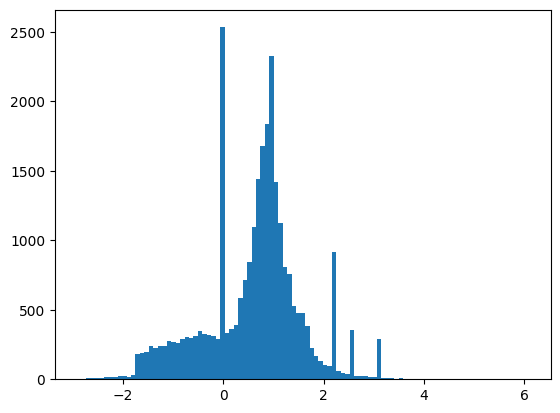

In [9]:
# Inspect some of the records from this new packed_ds
for features, label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [10]:
# to keep this tutorial short, use just the first 1,000 samples for validation, and the next 10,000 for training
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [11]:
# use the Dataset.cache method to ensure that the loader doesn't need to re-read
# the data from the file on each epoch

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [12]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [13]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [14]:
# Demonstrate overfitting
# many models train better if you gradually reduce the learning rate during training.

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH * 1000,
    decay_rate = 1,
    staircase = False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

Text(0, 0.5, 'Learning Rate')

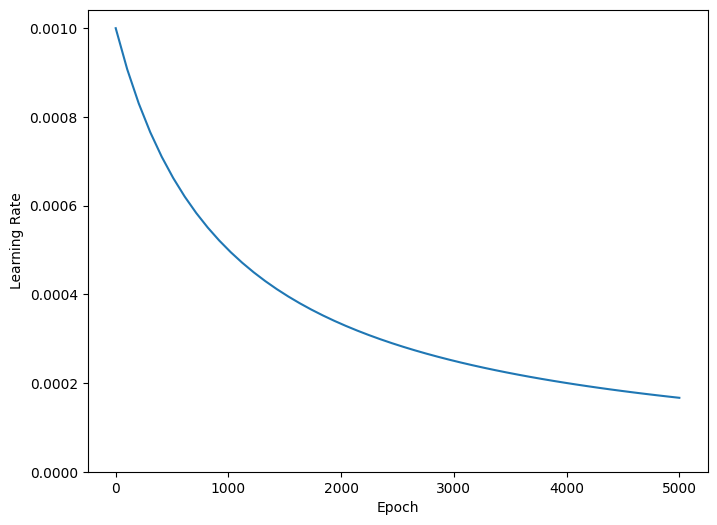

In [15]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize = (8, 6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

In [16]:
# each model in this tutorial will use the same training configuration. So set this up
# in a reusable way, starting with the list of callbacks.

def get_callbacks(name):
  return [
      tensorflow_docs.modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_crossentropy', patience = 200),
      tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [17]:
# similarly each model will use the same Model.compile and Model.fit settings

def compile_and_fit(model, name, optimizer = None, max_epochs = 10000):

  if optimizer is None:
    optimizer = get_optimizer()

  model.compile(
      optimizer = optimizer,
      loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
      metrics = [tf.keras.metrics.BinaryCrossentropy(from_logits = True, name = 'binary_crossentropy'), 'accuracy']
  )

  model.summary()

  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs = max_epochs,
      validation_data = validate_ds,
      callbacks = get_callbacks(name),
      verbose = 0
  )

  return history

In [18]:
# Tiny Model
tiny_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation = 'elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1)
])

In [19]:
size_histories = {}

In [20]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.5031,  binary_crossentropy:0.7872,  loss:0.7872,  val_accuracy:0.5140,  val_binary_crossentropy:0.7326,  val_loss:0.7326,  
....................................................................................................
Epoch: 100, accuracy:0.6043,  binary_crossentropy:0.6241,  loss:0.6241,  val_accuracy:0.5550,  val_binary_crossentropy:0.6306,  val_loss:0.6306,  
............................

(0.5, 0.7)

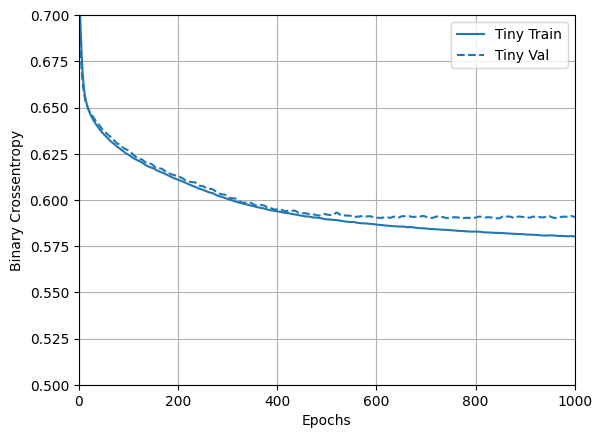

In [21]:
# now check how the model did

plotter = tensorflow_docs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std = 10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [22]:
# Small Model
# try 2 hidden layers with 16 units each

small_model = tf.keras.Sequential([
    # input_shape is only required here so that '.summary' works
    tf.keras.layers.Dense(16, activation = 'elu', input_shape = (FEATURES,)),
    tf.keras.layers.Dense(16, activation = 'elu'),
    tf.keras.layers.Dense(1)
])

In [23]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4717,  binary_crossentropy:0.7137,  loss:0.7137,  val_accuracy:0.4600,  val_binary_crossentropy:0.7060,  val_loss:0.7060,  
....................................................................................................
Epoch: 100, accuracy:0.6103,  binary_cros

In [26]:
# Medium model
# now try three hidden layers with 64 units each

medium_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'elu', input_shape = (FEATURES,)),
    tf.keras.layers.Dense(64, activation = 'elu'),
    tf.keras.layers.Dense(64, activation = 'elu'),
    tf.keras.layers.Dense(1)
])

In [27]:
size_histories['Medium'] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10241 (40.00 KB)
Trainable params: 10241 (40.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.5085,  binary_crossentropy:0.6931,  loss:0.6931,  val_accuracy:0.4730,  val_binary_crossentropy:0.6823,  val_loss:0.6823,  
....

In [28]:
# Large Model
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation = 'elu', input_shape = (FEATURES, )),
    tf.keras.layers.Dense(512, activation = 'elu'),
    tf.keras.layers.Dense(512, activation = 'elu'),
    tf.keras.layers.Dense(512, activation = 'elu'),
    tf.keras.layers.Dense(1)
])

In [29]:
size_histories['large'] = compile_and_fit(large_model, 'sizes/large')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac